# Semantic Segmentation of satellite imagery using U-Net
## Step 1: Data preparation

Based on the [tutorial by Dr. Sreenivas Bhattiprolu](https://www.youtube.com/watch?v=0W6MKZqSke8) ([Code on Github](https://github.com/bnsreenu/python_for_microscopists/tree/master/230_landcover_dataset_segmentation))

Dataset: https://www.kaggle.com/datasets/adrianboguszewski/landcoverai?resource=download

Tasks:

1. Read large images and corresponding masks, divide them into smaller patches.
   And write the patches as images to the local drive.

2. Save only images and masks where masks have some decent amount of labels other than 0.
   Using blank images with label=0 is a waste of time and may bias the model towards
   unlabeled pixels.

3. Divide the sorted dataset from above into train and validation datasets.

4. You have to manually move some folders and rename appropriately if you want to use
   ImageDataGenerator from keras.


In [1]:
# Necessary because of a bug https://github.com/qubvel/segmentation_models/issues/374
%env SM_FRAMEWORK=tf.keras

# Add the parent directory to the path to make imports work
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

env: SM_FRAMEWORK=tf.keras


In [2]:
import shutil
from pathlib import Path

import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import splitfolders
from IPython.display import clear_output
from matplotlib.colors import BoundaryNorm, ListedColormap
from patchify import patchify
from tqdm.auto import tqdm

from src import plot, prepare_data

In [3]:
# Define directory paths
dir_root = Path("..")
dir_data = Path(dir_root, "data")
dir_data_landcover = Path(dir_data, "landcover_ai/")

dir_img = Path(dir_data_landcover, "images")
dir_mask = Path(dir_data_landcover, "masks")
dir_patch = Path(dir_data_landcover, "patches")
dir_patch_img = Path(dir_patch, "images")
dir_patch_mask = Path(dir_patch, "masks")
dir_patch_useful_img = Path(dir_patch, "useful/images")
dir_patch_useful_mask = Path(dir_patch, "useful/masks")

# Define file paths
inventory_path = Path(dir_data_landcover, "inventory.csv")
inventory_short_path = Path(dir_data_landcover, "inventory_short.csv")

# Create directories if they don't exist
for dir in [
    dir_data_landcover,
    dir_img,
    dir_mask,
    dir_patch,
    dir_patch_img,
    dir_patch_mask,
    dir_patch_useful_img,
    dir_patch_useful_mask,
]:
    Path(dir).mkdir(parents=True, exist_ok=True)

In [4]:
classes = {0: "Not classified", 1: "Building", 2: "Woodland", 3: "Water", 4: "Roads"}

#### Visualize the three RGB bands of a random image


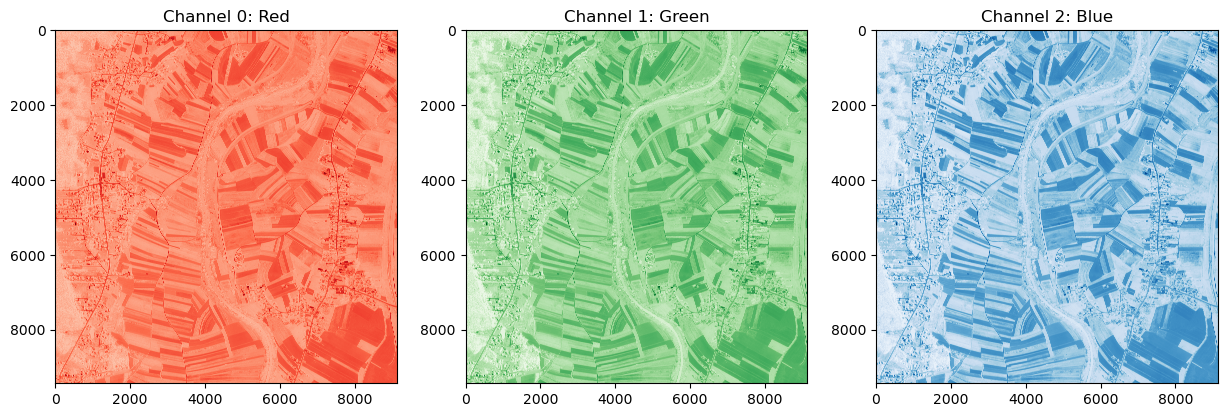

In [5]:
# Get paths of all images
img_files = [file for file in dir_img.iterdir()]

# Image with buildings
# img_path = Path(dir_img, "N-33-130-A-d-4-4.tif")

# Image with water
# img_path = Path(dir_img, "M-33-20-D-d-3-3.tif")

# Image with roads and buildings
img_path = Path(dir_img, "M-34-6-A-d-2-2.tif")

# Get random image from all images
img_path = np.random.choice(img_files)

plot.plot_image_channels(img_path)


#### Visualize the mask for the same image


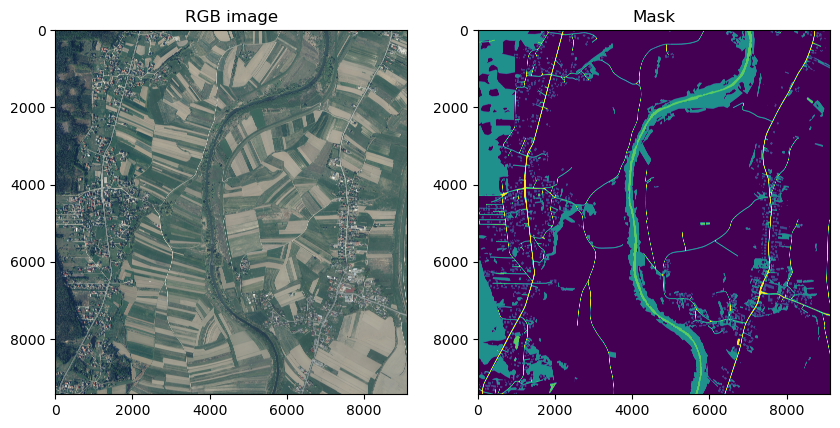

In [6]:
mask_path = Path(str(img_path).replace("/images/", "/masks/"))
plot.plot_image_and_mask(img_path, mask_path)

In [7]:
mask_path = Path(img_path.as_posix().replace("/images/", "/masks/"))
mask = cv2.imread(mask_path.as_posix())

# Can be checked for each channel. All channels are identical
labels, count = np.unique(mask[:, :, 0], return_counts=True)
print(
    f"Labels are:\n\n"
    f"{labels[0]}. Background: {count[0]:,} ({count[0]/np.sum(count):.2%})\n"
    f"{labels[1]}. Buildings: {count[1]:,} ({count[1]/np.sum(count):.2%})\n"
    f"{labels[2]}. Woodland: {count[2]:,} ({count[2]/np.sum(count):.2%})\n"
    f"{labels[3]}. Water: {count[3]:,} ({count[3]/np.sum(count):.2%})\n"
    f"{labels[4]}. Roads: {count[4]:,} ({count[4]/np.sum(count):.2%})"
)

Labels are:

0. Background: 70,871,416 (82.26%)
1. Buildings: 2,383,416 (2.77%)
2. Woodland: 10,234,029 (11.88%)
3. Water: 825,946 (0.96%)
4. Roads: 1,835,873 (2.13%)


### Crop each large image into patches of 256x256


In [8]:
# Run the function to create patches for images
prepare_data.create_patches(dir_img, dir_patch_img)

Patchifying image: ../data/landcover_ai/images/M-34-32-B-a-4-3.tif
Created 0 patches in ../data/landcover_ai/patches/images.
Skipped 1295 already existing patches.
Patchifying image: ../data/landcover_ai/images/N-34-140-A-b-4-2.tif
Created 0 patches in ../data/landcover_ai/patches/images.
Skipped 1258 already existing patches.
Patchifying image: ../data/landcover_ai/images/N-33-139-C-d-2-2.tif
Created 0 patches in ../data/landcover_ai/patches/images.
Skipped 1295 already existing patches.
Patchifying image: ../data/landcover_ai/images/M-33-20-D-c-4-2.tif
Created 0 patches in ../data/landcover_ai/patches/images.
Skipped 1295 already existing patches.
Patchifying image: ../data/landcover_ai/images/N-33-60-D-d-1-2.tif
Created 0 patches in ../data/landcover_ai/patches/images.
Skipped 288 already existing patches.
Patchifying image: ../data/landcover_ai/images/M-34-65-D-c-4-2.tif
Created 0 patches in ../data/landcover_ai/patches/images.
Skipped 1260 already existing patches.
Patchifying ima

In [9]:
# Run the function to create patches for masks
prepare_data.create_patches(dir_mask, dir_patch_mask)


Patchifying image: ../data/landcover_ai/masks/M-34-32-B-a-4-3.tif
Created 0 patches in ../data/landcover_ai/patches/masks.
Skipped 1295 already existing patches.
Patchifying image: ../data/landcover_ai/masks/N-34-140-A-b-4-2.tif
Created 0 patches in ../data/landcover_ai/patches/masks.
Skipped 1258 already existing patches.
Patchifying image: ../data/landcover_ai/masks/N-33-139-C-d-2-2.tif
Created 0 patches in ../data/landcover_ai/patches/masks.
Skipped 1295 already existing patches.
Patchifying image: ../data/landcover_ai/masks/M-33-20-D-c-4-2.tif
Created 0 patches in ../data/landcover_ai/patches/masks.
Skipped 1295 already existing patches.
Patchifying image: ../data/landcover_ai/masks/N-33-60-D-d-1-2.tif
Created 0 patches in ../data/landcover_ai/patches/masks.
Skipped 288 already existing patches.
Patchifying image: ../data/landcover_ai/masks/M-34-65-D-c-4-2.tif
Created 0 patches in ../data/landcover_ai/patches/masks.
Skipped 1260 already existing patches.
Patchifying image: ../data/

### Create patch inventory


In [10]:
inventory = prepare_data.create_patch_inventory(dir_patch_mask, inventory_path, classes)

File ../data/landcover_ai/inventory.csv already exists. Loading DataFrame...


In [11]:
inventory

,img,0,1,2,3,4,total,0_pct,1_pct,2_pct,3_pct,4_pct,useful_pct
0,M-33-7-A-d-3-2_patch_6_26.tif,151215.0,0.0,33630.0,0.0,11763.0,196608,0.769119,0.000000,0.171051,0.000000,0.059830,0.230881
1,N-34-77-A-b-1-4_patch_33_29.tif,168708.0,0.0,14943.0,0.0,12957.0,196608,0.858093,0.000000,0.076004,0.000000,0.065903,0.141907
2,N-33-60-D-d-1-2_patch_4_6.tif,0.0,0.0,0.0,196608.0,0.0,196608,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
3,M-34-68-B-a-1-3_patch_27_20.tif,140058.0,0.0,56550.0,0.0,0.0,196608,0.712372,0.000000,0.287628,0.000000,0.000000,0.287628
4,N-34-106-A-c-1-3_patch_25_32.tif,174219.0,0.0,0.0,22389.0,0.0,196608,0.886124,0.000000,0.000000,0.113876,0.000000,0.113876
...,...,...,...,...,...,...,...,...,...,...,...,...,...
44117,M-33-20-D-c-4-2_patch_3_22.tif,0.0,0.0,196608.0,0.0,0.0,196608,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000
44118,M-34-6-A-d-2-2_patch_6_3.tif,141669.0,6603.0,0.0,0.0,48336.0,196608,0.720566,0.033585,0.000000,0.000000,0.245850,0.279434
44119,N-34-106-A-b-3-4_patch_1_33.tif,196608.0,0.0,0.0,0.0,0.0,196608,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
44120,N-34-61-B-a-1-1_patch_1_13.tif,0.0,0.0,196608.0,0.0,0.0,196608,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000


### Select patches containing relevant information

Copy patches and masks with real information to a new folder.


In [12]:
prepare_data.select_useful_patches(
    dir_patch_img,
    dir_patch_mask,
    dir_patch_useful_img,
    dir_patch_useful_mask,
    inventory_short_path,
    classes,
)

Added 500 images with class 1.
Added 500 images with class 2.
Added 500 images with class 3.
Added 500 images with class 4.
2000 useful images in list.
0 missing in source.
2000 copied.


### Visualize classes in patches

In [13]:
inventory_useful = prepare_data.create_patch_inventory(dir_patch_useful_mask, Path(dir_data_landcover, "inventory_useful.csv"), classes)

File ../data/landcover_ai/inventory_useful.csv already exists. Loading DataFrame...


Text(0.5, 1.0, 'Roads')

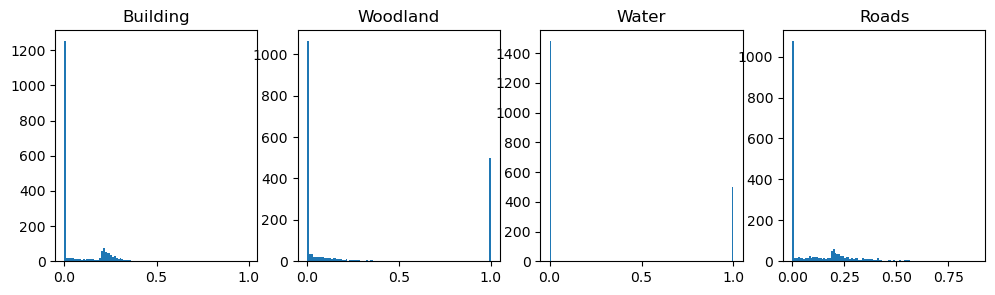

In [14]:
# Plot a histograms in subplots for 1_pct, 2_pct, 3_pct, 4_pct in inventory_useful
fig, axs = plt.subplots(1, 4, figsize=(12, 3))
axs[0].hist(inventory_useful["1_pct"], bins=100);
axs[0].set_title(classes[1])
axs[1].hist(inventory_useful["2_pct"], bins=100);
axs[1].set_title(classes[2])
axs[2].hist(inventory_useful["3_pct"], bins=100);
axs[2].set_title(classes[3])
axs[3].hist(inventory_useful["4_pct"], bins=100);
axs[3].set_title(classes[4])

### Plot random patch alongside its mask


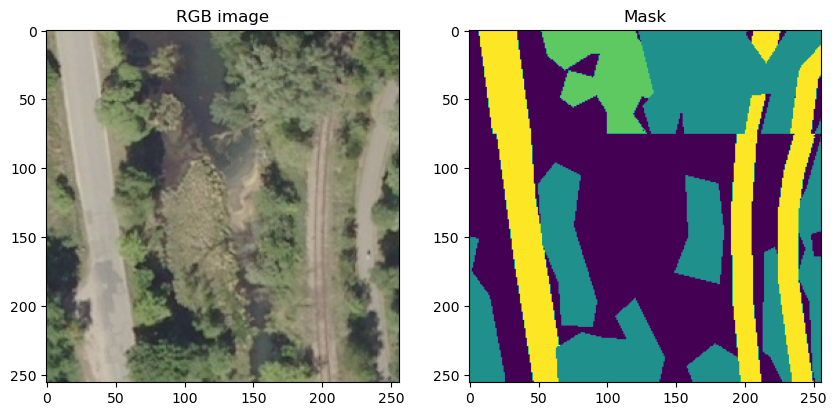

In [15]:
# Get paths of all patches
patch_files = [file for file in dir_patch_useful_img.iterdir()]

# Randomly select one of them
patch_path = np.random.choice(patch_files)

mask_path = Path(str(patch_path).replace("/images/", "/masks/"))

plot.plot_image_and_mask(patch_path, mask_path)


### Split the data into training, validation and testing


In [188]:
input_folder = Path(dir_patch, "useful")
output_folder = Path(dir_data_landcover, "tmp")

# Delete output_folder if it exists
if output_folder.is_dir():
    shutil.rmtree(str(output_folder))

for dir in [input_folder, output_folder]:
    Path(dir).mkdir(parents=True, exist_ok=True)

# Split with a ratio
# To only split into training and validation set, set a tuple to ratio, i.e, `(.8, .2)`.
splitfolders.ratio(
    input_folder, output=output_folder, seed=42, ratio=(0.75, 0.25), group_prefix=None
)


Copying files: 4000 files [00:00, 4261.65 files/s]


### Move files to final destination


In [189]:
move_files = {
    "train/images/": "train_images/train/",
    "train/masks/": "train_masks/train/",
    "val/images/": "val_images/val/",
    "val/masks/": "val_masks/val/",
}

for source, dest in move_files.items():
    source = Path(output_folder, source)
    dest = Path(dir_data_landcover, dest)

    # Delete destination if it exists
    if dest.is_dir():
        shutil.rmtree(str(dest))
    
    # Make sure destination exists
    Path(dest).mkdir(parents=True, exist_ok=True)

    counter = 0

    for file in source.iterdir():
        if file.is_file():
            file.rename(Path(dest, file.name))
            counter += 1

    print(f"Moved {counter} files from {source} to {dest}.")


Moved 1500 files from ../data/landcover_ai/tmp/train/images to ../data/landcover_ai/train_images/train.
Moved 1500 files from ../data/landcover_ai/tmp/train/masks to ../data/landcover_ai/train_masks/train.
Moved 500 files from ../data/landcover_ai/tmp/val/images to ../data/landcover_ai/val_images/val.
Moved 500 files from ../data/landcover_ai/tmp/val/masks to ../data/landcover_ai/val_masks/val.


### Remove temporary directory


In [190]:
files_left = 0

# Count number of files left
for file in output_folder.rglob("*"):
    if file.is_file():
        files_left += 1

if files_left == 0:
    shutil.rmtree(output_folder)
    print(f"Removed empty directory {output_folder}.")
else:
    print(f"{output_folder} not empty, did not remove.")


Removed empty directory ../data/landcover_ai/tmp.
